In [0]:
import keras
import numpy as np
import os
import math
from random import shuffle
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from skimage import io
from keras.utils import plot_model
from matplotlib import pyplot as plt
from IPython.display import clear_output
import scipy.io.wavfile
from contextlib import redirect_stdout
import json


#normalize unsigned 8-bits numpy array to [0;1]
def normalize_u8bits(data):
  data = data.astype(float)
  data /= 255.0
  return data

#normalize signed 16-bits numpy array to [-1;1]
def normalize_16bits(data):
  data = data.astype(float)
  data = (((data+32768)*(2))/65535)-1
  return data

#transform one np array as an array of overlapping smaller arrays of height time_steps
def window_reshape(data, time_steps, predictions):
  reshaped = []
  for i in range(0, data.shape[0]+1-time_steps, predictions):
    reshaped.append(data[i:i+time_steps,:])
  return np.array(reshaped)

#generate a perfect sine wave with amplitude range [-1;1] in a format ready for goal
def generate_sine(freq, size, offset, predictions):
  timestep = 1.0/104000.0
  sine = []
  block = []
  for i in range(size):
    amp = math.cos(2*math.pi*freq*(i+offset)*timestep)
    block.append(amp)
    if (i+1) % predictions == 0:
      sine.append(block)
      block = []
  return np.array(sine)

#plot two metrics and save in result folder
def plot_and_save(metric_val, metric_test, x_max, title, metric_name, time_step_name):
  length = len(metric_train)
  plt.plot(range(x_max), metric_val, label="validation results")
  plt.plot(range(x_max), metric_test, label="test results")
  plt.set_title(title)
  plt.set_ylabel(metric_name)
  plt.set_xlabel(time_step_name)
  plt.legend()
  plt.savefig(os.path.join(result_dir, title+'.png'))
  plt.close()

#create model
def create_model(filter_shapes, 
                 time_steps, 
                 img_width, 
                 activation_function, 
                 max_pool_shape, 
                 dropout_rate, 
                 predictions, 
                 padding,
                 learning_rate,
                 decay,
                 model_dir,
                 model_name):
  model = Sequential()
  model.add(Conv2D(32, filter_shapes[0],
                   input_shape=(time_steps, img_width, 1), padding=padding))
  model.add(Activation(activation_function))
  model.add(Conv2D(32, filter_shapes[1], padding=padding))
  model.add(Activation(activation_function))
  model.add(MaxPooling2D(pool_size=max_pool_shape))
  model.add(Dropout(dropout_rate))
  
  model.add(Conv2D(64, filter_shapes[2], padding=padding))
  model.add(Activation(activation_function))
  model.add(Conv2D(64, filter_shapes[3], padding=padding))
  model.add(Activation(activation_function))
  model.add(MaxPooling2D(pool_size=max_pool_shape))   
  model.add(Dropout(dropout_rate))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation(activation_function))
  model.add(Dropout(dropout_rate*2))
  model.add(Dense(predictions))
  model.add(Activation('tanh'))
  
  opt = keras.optimizers.rmsprop(lr=learning_rate, decay=decay)

  model.compile(loss='mean_squared_error',
                optimizer=opt,
                metrics=['mean_absolute_error', 'mean_squared_error'])
            
  with open(os.path.join(model_dir, model_name+'_parameters.txt'), 'w') as f:
    f.write('time_steps_a : '+str(time_steps)+'\n')
    f.write('predictions : ' + str(predictions)+'\n')
    f.write('filter_shapes : '+str(filter_shapes)+'\n')
    f.write('max_pool_shape : '+str(max_pool_shape)+'\n')
    f.write('dropout_rate : '+str(dropout_rate)+'\n')
    f.write('activation : '+activation_function+'\n')
    f.write('padding : '+padding+'\n')
    f.write('learning_rate : '+str(learning_rate)+'\n')
    f.write('decay : '+str(decay)+'\n')
  
  model_first_save(model, model_dir, model_name)
  return model
  
def model_first_save(model, model_dir, model_name):
  if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

  plot_model(model, to_file=os.path.join(model_dir, model_name+'_architecture.png'), show_shapes=True, show_layer_names=False)
  with open(os.path.join(model_dir, model_name+'_summary.txt'), 'w') as f:
    with redirect_stdout(f):
        model.summary()

def noising(img):
    row, col, ch = img.shape
    gauss = np.random.normal(0,1,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = img + gauss
    return noisy
        
def fit_model(model, images, time_steps, predictions, batch_size, epoch):
  counter=1
  for image_name in images:
    print('image '+str(counter)+'/'+str(len(images)))
    counter+=1
    img = io.imread(os.path.join(img_train_dir, image_name) , as_gray=True)
    img = noising(img)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    img_norm = normalize_u8bits(img)
    x_train = window_reshape(img_norm, time_steps, predictions)

    freq = int(image_name[1:image_name.find('_')])

    y_train = generate_sine(freq, x_train.shape[0]*predictions, (time_steps//2)-(predictions//2), predictions)

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epoch,
                        initial_epoch=epoch-1,
                        shuffle=True,
                        validation_split=0.15,
                        verbose=0)
  return history
  
def test_model(model, time_steps, predictions):
  testing = os.listdir(img_test_dir)
  i = 0
  glob_scores = []
  for test in testing:
    img_test = io.imread(os.path.join(img_test_dir, test) , as_gray=True)
    img_test = img_test.reshape(img_test.shape[0], img_test.shape[1], 1)
    img_test_normalized = normalize_u8bits(img_test)
    x_test = window_reshape(img_test_normalized, time_steps, predictions)

    freq_test = int(test[1:test.find('_')])
    y_test = generate_sine(freq_test, x_test.shape[0]*predictions, (time_steps//2)-(predictions//2), predictions)
    
    scores = model.evaluate(x_test, y_test)
    #print(scores)
    glob_scores.append(scores)
  means = np.mean(glob_scores, axis=0)
  #print(means)
  
  return means
  
#-----------MAIN----------------
#dir paths
models_dir = '/content/drive/My Drive/models'
results_dir = '/content/drive/My Drive/results'
img_train_dir = "/content/drive/My Drive/dataset_grooves/images/train"
img_test_dir = "/content/drive/My Drive/dataset_grooves/images/test"
best_results_file = os.path.join(results_dir, 'best_results.txt')

model_version_start = 1 #for output numbering

#network hyper-parameters, default values
epoch_start = 1
epochs = 5
batch_size = 32
#time_steps = 5
predictions = 1
filter_shapes = [(5,10),(5,10),(5,10),(5,10)]
img_width = 204
learning_rate = 0.0001
decay = 1e-6
steps_for_testing = 100 # 1 step = 1 image
max_pool_shape = (2, 2)
dropout_rate = 0.25
activation_function = 'relu'
padding='same'

current_epoch = 1
current_mv = 15

for epoch in range(epoch_start,epochs+epoch_start):
  
  model_version = model_version_start
  
  images = os.listdir(img_train_dir)
  shuffle(images)
  
  
  #finding best combination of filter shape, window size, and n of predictions
  with open(best_results_file, 'a') as f:
    f.write('-------- Comparing filters, window, no of pred ----------------')
    
  for time_steps_a in range(5, 12, 2):
    for predictions in range(1, time_steps_a+1, 2):
      for filter_h in range(3,(time_steps_a//2)+2):
        for filter_w in range(3, 11, 2):
          
          if(epoch < current_epoch+1 and model_version < current_mv+1):
            print('Skipping v.'+str(model_version)+' at epoch '+str(epoch))
            model_version+=1
            continue
          
          model_name = 'model'+str(model_version)
          
          print(model_name+', epoch '+str(epoch))
          model_dir = os.path.join(models_dir, model_name)
          if not os.path.isdir(model_dir):
            os.makedirs(model_dir)
          
          #loading model
          if epoch > 1:
            model = load_model(os.path.join(model_dir, model_name+'_epoch'+str(epoch-1)+'.h5'))
          else:
            
            filter_shapes = [(filter_h, filter_w),(filter_h, filter_w),(filter_h, filter_w),(filter_h, filter_w)]
            
            model = create_model(filter_shapes=filter_shapes,
                                time_steps=time_steps_a,
                                img_width=img_width,
                                activation_function=activation_function,
                                max_pool_shape=max_pool_shape,
                                dropout_rate=dropout_rate,
                                predictions=predictions,
                                padding=padding,
                                learning_rate = learning_rate,
                                decay = decay,
                                model_dir = model_dir,
                                model_name = model_name)
          
          #fitting model over one epoch
          train_results = fit_model(model, images, time_steps_a, predictions, batch_size, epoch)
          
          #saving model
          model.save(os.path.join(model_dir, model_name+'_epoch'+str(epoch)+'.h5'))
          
          #testing model
          test_results = test_model(model, time_steps_a, predictions)
          
          #appending results
          result_dir = os.path.join(results_dir, model_name)
          if epoch==1:
            results = {}
            results['mae_validation']={}
            results['mse_validation']={}
            results['mae_test']={}
            results['mse_test']={}
            if not os.path.isdir(result_dir):
              os.makedirs(result_dir)
          else:
            with open(os.path.join(result_dir, model_name+'_results.json'), 'r') as fp:
              results = json.load(fp)
                      
          results['mae_validation'][epoch] = train_results.history['val_mean_absolute_error']
          results['mse_validation'][epoch] = train_results.history['val_mean_squared_error']
          results['mae_test'][epoch] = test_results[1]
          results['mse_test'][epoch] = test_results[0]
                      
          with open(os.path.join(result_dir, model_name+'_results.json'), 'w') as f:
            json.dump(results, f)
          
          model_version += 1

     
          #with open('/content/drive/My Drive/output/std_out_v5.txt', 'a') as out_file:
            #out_file.write(str(step_count)+' - '+image_name+' : mse = '+str(history.history['mean_squared_error'])+'\n')
          #plot_and_save(mse_train, mae_train, mse_test, mae_test, False)

          #---------- TEST MODEL ------------
          '''
          goal = generate_sine(freq_test, x_test.shape[0], time_steps/2)

          goal = goal.astype(float)
          prediction = prediction.astype(float)

          goal_audio = np.column_stack((goal, goal))
          pred_audio = np.column_stack((prediction, prediction))

          scipy.io.wavfile.write('/content/drive/My Drive/output/f'+str(freq_test)+'_step'+str(step_count)+'_v5_goal.wav', 104000, goal_audio)
          scipy.io.wavfile.write('/content/drive/My Drive/output/f'+str(freq_test)+'_step'+str(step_count)+'_v5_pred.wav', 104000, pred_audio)

          step_count += 1
          '''

In [0]:
#MAKE A PREDICTION
import keras
import numpy as np
import os
import math
from random import shuffle
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from skimage import io
from keras.utils import plot_model
from matplotlib import pyplot as plt
from IPython.display import clear_output
import scipy.io.wavfile
from contextlib import redirect_stdout
import json

predictions = 1
time_steps = 15
model_version = 5000
epoch = 4

#generate a perfect sine wave with amplitude range [-1;1] in a format ready for goal
def generate_sine(freq, size, offset, predictions):
  timestep = 1.0/104000.0
  sine = []
  block = []
  for i in range(size):
    amp = math.cos(2*math.pi*freq*(i+offset)*timestep)
    block.append(amp)
    if (i+1) % predictions == 0:
      sine.append(block)
      block = []
  return np.array(sine)

#normalize unsigned 8-bits numpy array to [0;1]
def normalize_u8bits(data):
  data = data.astype(float)
  data /= 255.0
  return data

#transform one np array as an array of overlapping smaller arrays of height time_steps
def window_reshape(data, time_steps, predictions):
  reshaped = []
  for i in range(0, data.shape[0]+1-time_steps, predictions):
    reshaped.append(data[i:i+time_steps,:])
  return np.array(reshaped)


model = load_model('/content/drive/My Drive/models/model'+str(model_version)+'/model'+str(model_version)+'_epoch'+str(epoch)+'.h5')
test = 'f1850_a14_e12_b11_g241_h80000.tif'

#img_test = io.imread('/content/drive/My Drive/dataset_grooves/random_grooves/noisy_test/'+test, as_gray=True)
img_test = io.imread('/content/drive/My Drive/disc_sim_data/noisy_test/f1850_a14_e12_b11_g241_h80000.tif', as_gray=True)
img_test = img_test.reshape(img_test.shape[0], img_test.shape[1], 1)
img_test_normalized = normalize_u8bits(img_test)
print('image loaded')
x_test = window_reshape(img_test_normalized, time_steps, predictions)
print('image reshaped')

freq_test = int(test[1:test.find('_')])

prediction = model.predict(x_test)
print('prediction made')

goal = generate_sine(freq_test, x_test.shape[0], time_steps/2, 1)

goal = goal.astype(float)
prediction = prediction.astype(float)

goal_audio = np.column_stack((goal, goal))
pred_audio = np.column_stack((prediction, prediction))

scipy.io.wavfile.write('/content/drive/My Drive/results/model'+str(model_version)+'/f'+str(freq_test)+'_epoch'+str(epoch)+'_v'+str(model_version)+'_goal.wav', 104000, goal_audio)
scipy.io.wavfile.write('/content/drive/My Drive/results/model'+str(model_version)+'/f'+str(freq_test)+'_epoch'+str(epoch)+'_v'+str(model_version)+'_pred.wav', 104000, pred_audio)

image loaded
image reshaped
prediction made


In [0]:
#GENERATE MODELS AROUND MAX POOL AND DROPOUT
import keras
import numpy as np
import os
import math
from random import shuffle
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from skimage import io
from keras.utils import plot_model
from matplotlib import pyplot as plt
from IPython.display import clear_output
import scipy.io.wavfile
from contextlib import redirect_stdout
import json


#normalize unsigned 8-bits numpy array to [0;1]
def normalize_u8bits(data):
  data = data.astype(float)
  data /= 255.0
  return data

#normalize signed 16-bits numpy array to [-1;1]
def normalize_16bits(data):
  data = data.astype(float)
  data = (((data+32768)*(2))/65535)-1
  return data

#transform one np array as an array of overlapping smaller arrays of height time_steps
def window_reshape(data, time_steps, predictions):
  reshaped = []
  for i in range(0, data.shape[0]+1-time_steps, predictions):
    reshaped.append(data[i:i+time_steps,:])
  return np.array(reshaped)

#generate a perfect sine wave with amplitude range [-1;1] in a format ready for goal
def generate_sine(freq, size, offset, predictions):
  timestep = 1.0/104000.0
  sine = []
  block = []
  for i in range(size):
    amp = math.cos(2*math.pi*freq*(i+offset)*timestep)
    block.append(amp)
    if (i+1) % predictions == 0:
      sine.append(block)
      block = []
  return np.array(sine)

#plot two metrics and save in result folder
def plot_and_save(metric_val, metric_test, x_max, title, metric_name, time_step_name):
  length = len(metric_train)
  plt.plot(range(x_max), metric_val, label="validation results")
  plt.plot(range(x_max), metric_test, label="test results")
  plt.set_title(title)
  plt.set_ylabel(metric_name)
  plt.set_xlabel(time_step_name)
  plt.legend()
  plt.savefig(os.path.join(result_dir, title+'.png'))
  plt.close()

#create model
def create_model(filter_shapes, 
                 time_steps, 
                 img_width, 
                 activation_function, 
                 max_pool_shape, 
                 dropout_rate, 
                 predictions, 
                 padding,
                 learning_rate,
                 decay,
                 model_dir,
                 model_name):
  model = Sequential()
  model.add(Conv2D(32, filter_shapes[0],
                   input_shape=(time_steps, img_width, 1), padding=padding))
  model.add(Activation(activation_function))
  model.add(Conv2D(32, filter_shapes[1], padding=padding))
  model.add(Activation(activation_function))
  if not max_pool_shape == (1,1):
      model.add(MaxPooling2D(pool_size=max_pool_shape))   
  if not dropout_rate==0.0:
    model.add(Dropout(dropout_rate))
  
  model.add(Conv2D(64, filter_shapes[2], padding=padding))
  model.add(Activation(activation_function))
  model.add(Conv2D(64, filter_shapes[3], padding=padding))
  model.add(Activation(activation_function))
  if not max_pool_shape == (1,1):
      model.add(MaxPooling2D(pool_size=max_pool_shape))
  if not dropout_rate==0.0:
    model.add(Dropout(dropout_rate))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation(activation_function))
  if not dropout_rate==0.0:
    model.add(Dropout(dropout_rate*2))
  model.add(Dense(predictions))
  model.add(Activation('tanh'))
  
  opt = keras.optimizers.rmsprop(lr=learning_rate, decay=decay)

  model.compile(loss='mean_squared_error',
                optimizer=opt,
                metrics=['mean_absolute_error', 'mean_squared_error'])
            
  with open(os.path.join(model_dir, model_name+'_parameters.txt'), 'w') as f:
    f.write('time_steps_a : '+str(time_steps)+'\n')
    f.write('predictions : ' + str(predictions)+'\n')
    f.write('filter_shapes : '+str(filter_shapes)+'\n')
    f.write('max_pool_shape : '+str(max_pool_shape)+'\n')
    f.write('dropout_rate : '+str(dropout_rate)+'\n')
    f.write('activation : '+activation_function+'\n')
    f.write('padding : '+padding+'\n')
    f.write('learning_rate : '+str(learning_rate)+'\n')
    f.write('decay : '+str(decay)+'\n')
  
  model_first_save(model, model_dir, model_name)
  return model
  
def model_first_save(model, model_dir, model_name):
  if not os.path.isdir(model_dir):
    os.makedirs(model_dir)

  plot_model(model, to_file=os.path.join(model_dir, model_name+'_architecture.png'), show_shapes=True, show_layer_names=False)
  with open(os.path.join(model_dir, model_name+'_summary.txt'), 'w') as f:
    with redirect_stdout(f):
        model.summary()

def fit_model(model, images, time_steps, predictions, batch_size, epoch):
  counter=1
  for image_name in images:
    print('image '+str(counter)+'/'+str(len(images)))
    counter+=1
    img = io.imread(os.path.join(img_train_dir, image_name) , as_gray=True)
    img = img.reshape(img.shape[0], img.shape[1], 1)
    img_norm = normalize_u8bits(img)
    x_train = window_reshape(img_norm, time_steps, predictions)

    freq = int(image_name[1:image_name.find('_')])

    y_train = generate_sine(freq, x_train.shape[0]*predictions, (time_steps//2)-(predictions//2), predictions)

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epoch,
                        initial_epoch=epoch-1,
                        shuffle=True,
                        validation_split=0.15,
                        verbose=0)
    return history
  
def test_model(model, time_steps, predictions):
  testing = os.listdir(img_test_dir)
  i = 0
  glob_scores = []
  for test in testing:
    img_test = io.imread(os.path.join(img_test_dir, test) , as_gray=True)
    img_test = img_test.reshape(img_test.shape[0], img_test.shape[1], 1)
    img_test_normalized = normalize_u8bits(img_test)
    x_test = window_reshape(img_test_normalized, time_steps, predictions)

    freq_test = int(test[1:test.find('_')])
    y_test = generate_sine(freq_test, x_test.shape[0]*predictions, (time_steps//2)-(predictions//2), predictions)
    
    scores = model.evaluate(x_test, y_test)
    #print(scores)
    glob_scores.append(scores)
  means = np.mean(glob_scores, axis=0)
  #print(means)
  
  return means
  
#-----------MAIN----------------
#dir paths
models_dir = '/content/drive/My Drive/models'
results_dir = '/content/drive/My Drive/results'
img_train_dir = "/content/drive/My Drive/dataset_grooves/images/train"
img_test_dir = "/content/drive/My Drive/dataset_grooves/images/test"
best_results_file = os.path.join(results_dir, 'best_results.txt')

model_version_start = 1000 #for output numbering

#network hyper-parameters, default values
epoch_start = 1
epochs = 5
batch_size = 32
time_steps = 5
predictions = 1
filter_shapes = [(3,3),(3,3),(3,3),(3,3)]
img_width = 204
learning_rate = 0.0001
decay = 1e-6
steps_for_testing = 100 # 1 step = 1 image
max_pool_shape = (2, 2)
dropout_rate = 0.25
activation_function = 'relu'
padding='same'

current_epoch = 1
current_mv = 0

for epoch in range(epoch_start,epochs+epoch_start):
  
  model_version = model_version_start
  
  images = os.listdir(img_train_dir)
  shuffle(images)
  for mph in range(1, 4):
      for mpw in range(1,4):
          for d in range(0, 35, 10):
              if(epoch < current_epoch+1 and model_version < current_mv+1):
                  print('Skipping v.'+str(model_version)+' at epoch '+str(epoch))
                  model_version+=1
                  continue
              
              model_name = 'model'+str(model_version)

              print(model_name+', epoch '+str(epoch))
              print('dropout = '+str(d)+'%')
              model_dir = os.path.join(models_dir, model_name)
              if not os.path.isdir(model_dir):
                os.makedirs(model_dir)

              #loading model
              if epoch > 1:
                model = load_model(os.path.join(model_dir, model_name+'_epoch'+str(epoch-1)+'.h5'))
              else:

                dropout_rate = d/100.0
                max_pool_shape = (mph, mpw)

                model = create_model(filter_shapes=filter_shapes,
                                    time_steps=time_steps,
                                    img_width=img_width,
                                    activation_function=activation_function,
                                    max_pool_shape=max_pool_shape,
                                    dropout_rate=dropout_rate,
                                    predictions=predictions,
                                    padding=padding,
                                    learning_rate = learning_rate,
                                    decay = decay,
                                    model_dir = model_dir,
                                    model_name = model_name)

              #fitting model over one epoch
              train_results = fit_model(model, images, time_steps, predictions, batch_size, epoch)

              #saving model
              model.save(os.path.join(model_dir, model_name+'_epoch'+str(epoch)+'.h5'))

              #testing model
              test_results = test_model(model, time_steps, predictions)

              #appending results
              result_dir = os.path.join(results_dir, model_name)
              if epoch==1:
                results = {}
                results['mae_validation']={}
                results['mse_validation']={}
                results['mae_test']={}
                results['mse_test']={}
                if not os.path.isdir(result_dir):
                  os.makedirs(result_dir)
              else:
                with open(os.path.join(result_dir, model_name+'_results.json'), 'r') as fp:
                  results = json.load(fp)

              results['mae_validation'][epoch] = train_results.history['val_mean_absolute_error']
              results['mse_validation'][epoch] = train_results.history['val_mean_squared_error']
              results['mae_test'][epoch] = test_results[1]
              results['mse_test'][epoch] = test_results[0]

              with open(os.path.join(result_dir, model_name+'_results.json'), 'w') as f:
                json.dump(results, f)

              model_version += 1

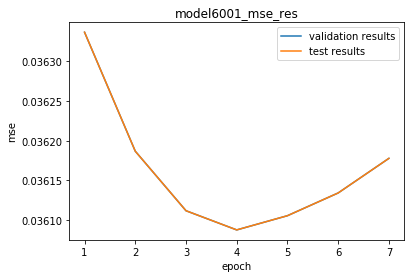

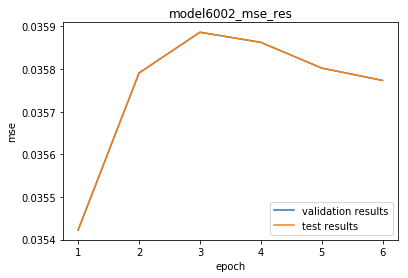

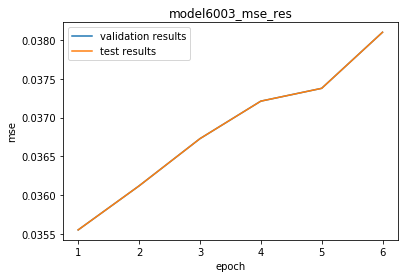

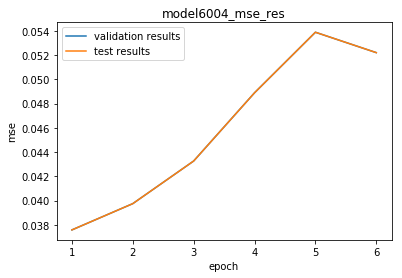

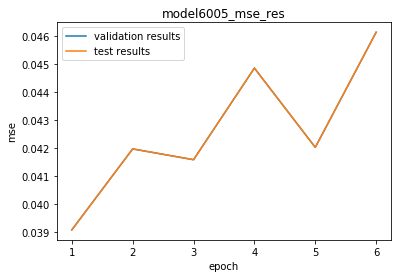

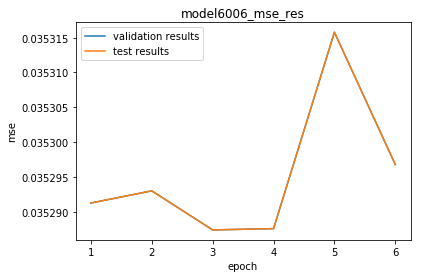

Best : model6006 at epoch 3 with score 0.03528737999492043

Second : model6006 at epoch 4 with score 0.0352875655257691

Third : model6006 at epoch 1 with score 0.03529124575127673



In [9]:
# FIND BEST MODEL

import os, json
from matplotlib import pyplot as plt

#plot two metrics and save in result folder
def plot_and_save(metric_val, metric_test, x_labels, title, metric_name, time_step_name, res_dir):
    plt.plot(x_labels, metric_val, label="validation results")
    plt.plot(x_labels, metric_test, label="test results")
    plt.title(title)
    plt.ylabel(metric_name)
    plt.xlabel(time_step_name)
    plt.legend()
    plt.show()
    plt.savefig(os.path.join(res_dir, title+'.png'))
    plt.close()
  
results_dir = '/content/drive/My Drive/results'
best_mse = [1.0, 1.0, 1.0]
best_epoch = [0,0,0]
best_model = ['','','']

def sorter(x):
  return float(x[0])

for i in range(6001, 6007):
    model_name = 'model'+str(i)
    result_dir = os.path.join(results_dir, model_name)
    with open(os.path.join(result_dir, model_name+'_results.json'), 'r') as fp:
        results = json.load(fp)
        
    #mse_test = results['mse_test']
    mse_test = results['mse_validation']
    
    sort_test = sorted(mse_test.items(), key=sorter) # sorted by key, return a list of tuples
    #sort_val = sorted(mse_val.items(), key=sorter)
    xt, yt = zip(*sort_test) # unpack a list of pairs into two tuples
    #xv, yv = zip(*sort_val)
    
    
    plot_and_save(yt, yt, xt, model_name+'_mse_res', 'mse', 'epoch', result_dir)
    
    for epoch in mse_test.keys():
        mse = mse_test[epoch][0]
        if mse < best_mse[0] :
            best_mse[2] = best_mse[1]
            best_mse[1] = best_mse[0]
            best_mse[0] = mse
            
            best_epoch[2] = best_epoch[1]
            best_epoch[1] = best_epoch[0]
            best_epoch[0] = epoch
            
            best_model[2] = best_model[1]
            best_model[1] = best_model[0]
            best_model[0] = model_name
        elif mse < best_mse[1] :
            best_mse[2] = best_mse[1]
            best_mse[1] = mse
            
            best_epoch[2] = best_epoch[1]
            best_epoch[1] = epoch
            
            best_model[2] = best_model[1]
            best_model[1] = model_name
        elif mse < best_mse[2] :
            best_mse[2] = mse
            best_epoch[2] = epoch
            best_model[2] = model_name
            
    
print('Best : '+best_model[0]+' at epoch '+str(best_epoch[0])+' with score '+str(best_mse[0])+'\n')
print('Second : '+best_model[1]+' at epoch '+str(best_epoch[1])+' with score '+str(best_mse[1])+'\n')
print('Third : '+best_model[2]+' at epoch '+str(best_epoch[2])+' with score '+str(best_mse[2])+'\n')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
